<a href="https://colab.research.google.com/github/msbeigi/sale-analysis/blob/main/backery_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirment

In [ ]:
!sudo pip install xgboost
!pip install catboost


In [2]:
import pandas as pd
import numpy as np
from IPython.display import display,HTML
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import plotly.graph_objects as go


## Initiation and Data Understanding

### Load Data

In [59]:
weather=pd.read_csv("/content/drive/MyDrive/ML/Hand-on/Backery/weather_2021.01.01-2022.10.31.csv")
backery=pd.read_csv("/content/drive/MyDrive/ML/Hand-on/Backery/bakery_sales_2021-2022.csv")
title='<h3>Sample content of Datsets:</h3>'
display(HTML(title))
title='<h3>bakery_sales_2021-2022.csv</h3>'
display(HTML(title))
display(backery.head(7))
title='<h3>weather_2021.01.01-2022.10.31.csv</h3>'
display(HTML(title))
display(weather.head(7))

,Unnamed: 0,date,time,ticket_number,Article,Quantity,UNIT_PRICE
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
5,11,2021-01-02,09:25,150043.0,BAGUETTE,2.0,"0,90 €"
6,12,2021-01-02,09:25,150043.0,CROISSANT,3.0,"1,10 €"


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-01-01,2.7,1.5,5.7,15.2,NaN,335.0,15.5,31.0,1008.6,NaN
1,2021-01-02,1.3,0.5,2.7,0.8,NaN,336.0,24.7,44.0,1010.1,NaN
2,2021-01-03,0.7,-0.3,1.6,0.0,NaN,327.0,17.1,38.9,1012.1,NaN
3,2021-01-04,0.0,-1.0,1.1,0.0,NaN,329.0,10.6,30.0,1011.4,NaN
4,2021-01-05,0.8,-0.9,2.1,0.0,NaN,338.0,6.2,30.0,1012.1,NaN
5,2021-01-06,0.8,0.2,1.4,0.0,NaN,324.0,8.0,21.0,1015.4,NaN
6,2021-01-07,0.2,-1.6,2.5,0.0,NaN,343.0,6.2,24.0,1017.1,NaN


### Summary Missing Values and Feature Types

In [60]:
meta_backery=['row index' 	,'date of sale ','time of sale ', 'receipt number ','product name ', 'quantity of the product','unit price of the product']
meta_weahter=['The date of the measurement', 'The average air temperature in °C', 'The minimum air temperature in °C','The maximum air temperature in °C'
              ,'The daily precipitation total in mm', 'The snow depth in mm', 'The average wind direction in degrees (°)', 'The average wind speed in km/h'
              ,'The peak wind gust in km/h', 'The average sea-level air pressure in hPa', 'The daily sunshine total in minutes (m)']


missing_values=backery.isna().sum()
missing_values_weather=weather.isna().sum()

feature_typ=backery.dtypes
feature_typ_weather=weather.dtypes

# out put for backery dataset
_=zip(missing_values.index,meta_backery,missing_values.values,feature_typ.values)
df_backer_desc = pd.DataFrame(_, columns=['column','feature_escription', 'number_of_missing_values', 'feature_type']).style.set_properties(**{'text-align': 'left'})
title = "<h3>Backery Dataset Summary with Missing Values and Data Types</h3>"
display(HTML(title))
display(df_backer_desc)
# output for weather dataset
_=zip(missing_values_weather.index,meta_weahter,missing_values_weather.values,feature_typ_weather.values)
df_weather_desc = pd.DataFrame(_, columns=['column','feature_description', 'number_of_missing_values', 'feature_type']).style.set_properties(**{'text-align': 'left'})
title = "<h3>Weather Dataset Summary with Missing Values and Data Types</h3>"
display(HTML(title))
display(df_weather_desc)


,column,feature_escription,number_of_missing_values,feature_type
0,Unnamed: 0,row index,0,int64
1,date,date of sale,0,object
2,time,time of sale,0,object
3,ticket_number,receipt number,0,float64
4,Article,product name,0,object
5,Quantity,quantity of the product,0,float64
6,UNIT_PRICE,unit price of the product,0,object


,column,feature_description,number_of_missing_values,feature_type
0,date,The date of the measurement,0,object
1,tavg,The average air temperature in °C,0,float64
2,tmin,The minimum air temperature in °C,0,float64
3,tmax,The maximum air temperature in °C,0,float64
4,prcp,The daily precipitation total in mm,0,float64
5,snow,The snow depth in mm,654,float64
6,wdir,The average wind direction in degrees (°),2,float64
7,wspd,The average wind speed in km/h,2,float64
8,wpgt,The peak wind gust in km/h,14,float64
9,pres,The average sea-level air pressure in hPa,2,float64


### Statistical Review

In [61]:
title='<h3>Statistical review</h3>'
display(HTML(title))
title='<h4>backery:</h4>'
display(HTML(title))
display(backery.describe())
title='<h4>weather:</h4>'
display(HTML(title))
display(weather.describe())


,Unnamed: 0,ticket_number,Quantity
count,234005.000000,234005.000000,234005.000000
mean,255205.035854,219201.258738,1.538377
std,147501.625992,40053.223896,1.289603
min,0.000000,150040.000000,-200.000000
25%,127979.000000,184754.000000,1.000000
50%,254573.000000,218807.000000,1.000000
75%,382911.000000,253927.000000,2.000000
max,511395.000000,288913.000000,200.000000


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,669.000000,669.000000,669.000000,669.000000,15.000000,667.000000,667.000000,655.000000,667.000000,0.0
mean,13.900747,9.552167,18.830344,2.272945,14.733333,225.757121,12.674813,39.014198,1018.422789,NaN
std,7.710498,6.918623,8.864005,7.402603,9.353889,108.937433,6.022562,14.485416,7.056279,NaN
min,-3.300000,-5.400000,-1.500000,0.000000,10.000000,0.000000,3.100000,11.000000,996.400000,NaN
25%,7.800000,3.800000,12.400000,0.000000,10.000000,155.000000,8.000000,28.000000,1014.200000,NaN
50%,14.200000,9.800000,19.500000,0.000000,10.000000,192.000000,11.300000,37.000000,1018.400000,NaN
75%,20.000000,15.600000,25.500000,0.800000,15.000000,338.500000,16.000000,46.300000,1022.300000,NaN
max,31.800000,24.800000,38.500000,103.400000,41.000000,359.000000,41.000000,93.000000,1039.300000,NaN


## Data preparation

### Missing Values

In [62]:
def drop_nonvalue(df :pd.DataFrame)->pd.DataFrame:
  """
  Args:
    df: weather dataset as dataframe input
  Returns:
    returns cleared dataframe of missing values
  """
  df.drop(['tsun','snow'], axis=1,inplace=True)

  return df

def impute_missing_values(df:pd.DataFrame)->pd.DataFrame:
    """
    Args:
      df: weather dataset as dataframe input
    Returns:
      return the modified DataFrame
    """
    columns_tobe_fill = ['wdir','wspd','wpgt','pres']
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
    df[columns_tobe_fill] = imputer.fit_transform(df[columns_tobe_fill])


    return df

In [63]:
df_weather=weather.copy()
df_weather=drop_nonvalue(df_weather)
df_weather=impute_missing_values(df_weather)
print('Number of missing values:\n----------------')
print(df_weather.isna().sum())


Number of missing values:
----------------
date    0
tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
wpgt    0
pres    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Anomalies

In [64]:
def drop_nodata_bakey(df: pd.DataFrame)->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without anomaly data
  """
  no_data_indice=df[df['Article']=='.'].index
  df.drop(no_data_indice, inplace=True)
  df['Article'] = df['Article'].str.strip()
  return df

def false_quantity(df: pd.DataFrame)-> pd.DataFrame:
  """
  Removes negative quanitities
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without negative quanitities
  """


  no_data_indice=df[df['Quantity']<=0].index
  df.drop(no_data_indice, inplace=True,axis=0)

  return df

def false_price(df: pd.DataFrame)-> pd.DataFrame:
  """
  Removes zero unit price
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without zero unit price
  """

  no_data_indice=df[df['UNIT_PRICE']=='0,00 €'].index
  df.drop(no_data_indice, inplace=True,axis=0)

  return df


## Feature Engineering

In [65]:
def encode_bakery(df: pd.DataFrame)->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset with encoded Article feature
  """
  label_encoder = LabelEncoder()
  df['Article_Label'] = label_encoder.fit_transform(df['Article'])
  return df


def onehot_encode_bakery(df: pd.DataFrame)  ->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset with encoded Article feature in oneHot
  """
  encoder = OneHotEncoder(sparse=False)
  article_encoded = encoder.fit_transform(df[['Article']])
  encode_columns=encoder.get_feature_names_out()
  encoded_df=pd.DataFrame(article_encoded,columns=encode_columns)
  df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
  return df

def added_feature_bakery(df: pd.DataFrame)-> pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return new dataset with added feature
  """

  df=df.rename(columns={'Unnamed: 0':'index'})

  df['unit_price_value']= df['UNIT_PRICE'].apply(lambda x: extract_price(x))
  # df["total_sale_item"]= df['Quantity']*df['unit_price_value']
  df=df.rename(columns={'Unnamed: 0':'index'})

  return df

def added_feature_weather(df: pd.DataFrame)-> pd.DataFrame:
  """
  Args:
   df: weather dataset as dataframe input
  Returns:
    return new dataset with added feature
  """
  df['is_rainy']=df['prcp']>0
  df['temp_range'] = df['tmax'] - df['tmin']
  df['is_cold_day'] = (df['tavg'] < 10).astype(int)
  df['is_hot_day'] = (df['tavg'] > 25).astype(int)
  df['is_heavy_wind'] = (df['wspd'] > 20).astype(int)
  df['is_high_pressure'] = (df['pres'] > 1015).astype(int)
  df['date'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

  df['day_of_week'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').dayofweek)
  df['day_name']= df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').day_name())
  df['is_weekend'] = df['day_name'].isin(['Saturday', 'Sunday']).astype(int)


  df['month'] = df['date'].dt.month
  df['week'] = df['date'].dt.isocalendar().week
  df['day'] = df['date'].dt.day

  fr_holidays = holidays.France()
  df['is_holiday'] = df['date'].apply(lambda x: x in fr_holidays)
  return df

def extract_price(price_tag: object)->float:
  """
  Args:
    price_tag: string input for daily sale with currency sign

  Returns:
    returns price value as float
  """
  price_string=str(price_tag)
  price_value=float(price_string[:-2].replace(',','.'))
  return price_value

In [66]:
df_bekery=backery.copy()

df_bekery=drop_nodata_bakey(df_bekery)
df_bekery=encode_bakery(df_bekery)
df_bekery=added_feature_bakery(df_bekery)
df_weather=added_feature_weather(df_weather)


df_bekery=false_price(df_bekery)
df_bekery=false_quantity(df_bekery)


In [67]:
daily_sales = df_bekery.groupby('date',as_index=False) ['Quantity'].sum().reset_index()
daily_sales['date']= pd.to_datetime(daily_sales['date'])
merged_data = pd.merge(daily_sales, df_weather, on='date')
# merged_data


### Outliers

In [18]:
Q1 = merged_data['Quantity'].quantile(0.25)
Q3 = merged_data['Quantity'].quantile(0.75)
IQR = Q3 - Q1

In [50]:

outliers = merged_data[(merged_data['Quantity'] < (Q1 - 1.5 * IQR)) | (merged_data['Quantity'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers: {len(outliers)}')
display(outliers)
merged_data_no_oulier = merged_data[~((merged_data['Quantity'] < (Q1 - 1.5 * IQR)) | (merged_data['Quantity'] > (Q3 + 1.5 * IQR)))]


Number of outliers: 0


,index,date,Quantity,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,...,is_hot_day,is_heavy_wind,is_high_pressure,day_of_week,day_name,is_weekend,month,week,day,is_holiday


### Feature importance

#### Features' Pearson correlation

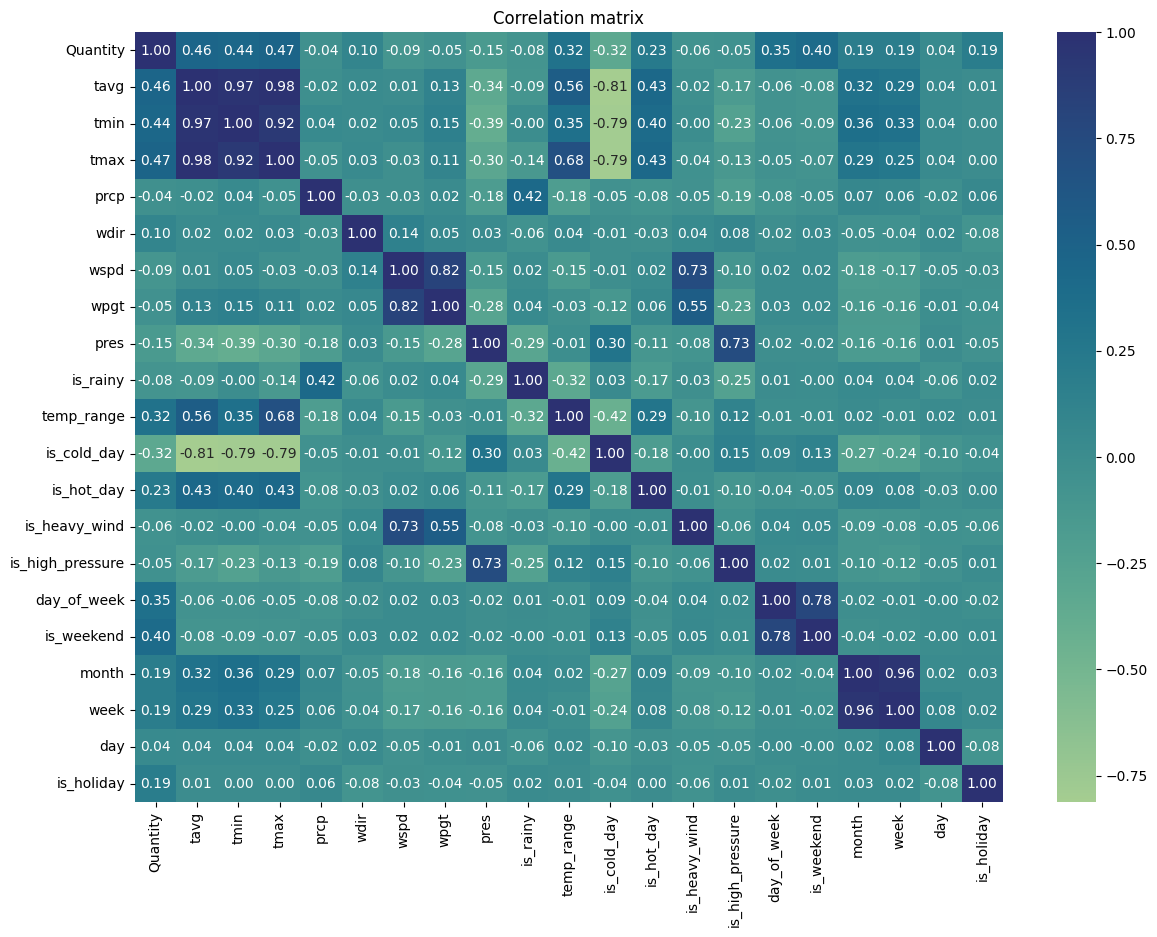

Correlation values with quantity:
Quantity            1.000000
tavg                0.463795
tmin                0.441013
tmax                0.474442
prcp               -0.038537
wdir                0.095716
wspd               -0.090454
wpgt               -0.051707
pres               -0.152776
is_rainy           -0.083589
temp_range          0.317002
is_cold_day        -0.324851
is_hot_day          0.230523
is_heavy_wind      -0.060993
is_high_pressure   -0.047762
day_of_week         0.345914
is_weekend          0.400252
month               0.187997
week                0.186739
day                 0.038833
is_holiday          0.194659
Name: Quantity, dtype: float64


In [51]:


correlation_merge=merged_data_no_oulier[[ 'Quantity', #'total_sale_item', 'Article_Label',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'is_heavy_wind',
       'is_high_pressure', 'day_of_week', 'is_weekend', 'month',
       'week', 'day', 'is_holiday']].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_merge, cmap='crest',annot=True, fmt='.2f',)
plt.title('Correlation matrix')
plt.show()
print('Correlation values with quantity:')
print(dict(correlation_merge)['Quantity'])


In [52]:
# correlation_merge[correlation_merge[]]['Quantity']

correl=dict(correlation_merge['Quantity'])
correl_list=[]
for i in correl:
    if(np.abs(correl[i])>0.01 and i!='Quantity'):
        correl_list.append(i)
print(f'Top features:\n{correl_list}')

Top features:
['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'is_heavy_wind', 'is_high_pressure', 'day_of_week', 'is_weekend', 'month', 'week', 'day', 'is_holiday']


In [53]:
df_train=merged_data_no_oulier[correl_list]
df_y=merged_data_no_oulier['Quantity']
X_train,X_test,y_train,y_test=train_test_split(df_train, df_y, test_size=0.3, random_state=42)


#### Feature imporatnce with LightGBMRegressor & ExtraTreesRegressor

In [ ]:


etr = ExtraTreesRegressor(n_estimators=300, random_state=42, verbose=0)
etr.fit(X_train, y_train)
feature_importances_etr = etr.feature_importances_

lgbm = lgb.LGBMRegressor(n_estimators=100,  random_state=42)
lgbm.fit(X_train, y_train)

feature_importances_lgbm = lgbm.feature_importances_


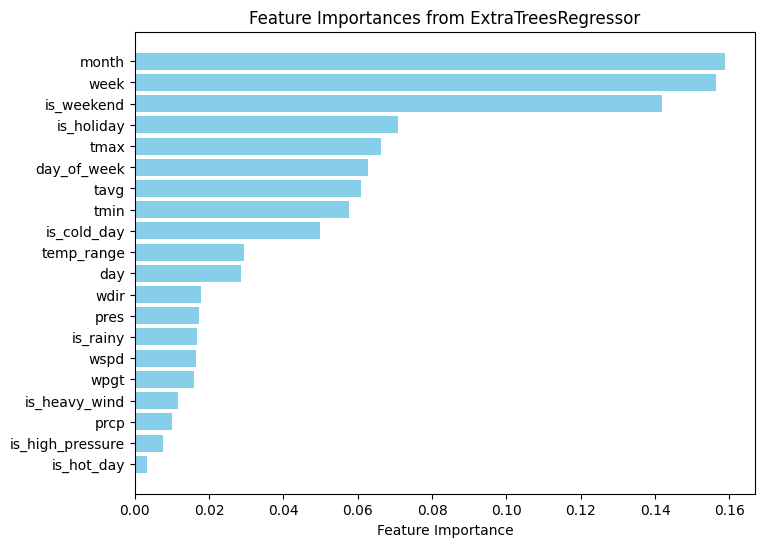


Top features from ExtraTreesRegressor: ['month' 'week' 'is_weekend' 'is_holiday' 'tmax' 'day_of_week' 'tavg'
 'tmin' 'is_cold_day' 'temp_range']


top features from LGBMRegressor:['week' 'pres' 'day' 'wdir' 'temp_range' 'day_of_week' 'tmax' 'wspd'
 'tmin' 'tavg']



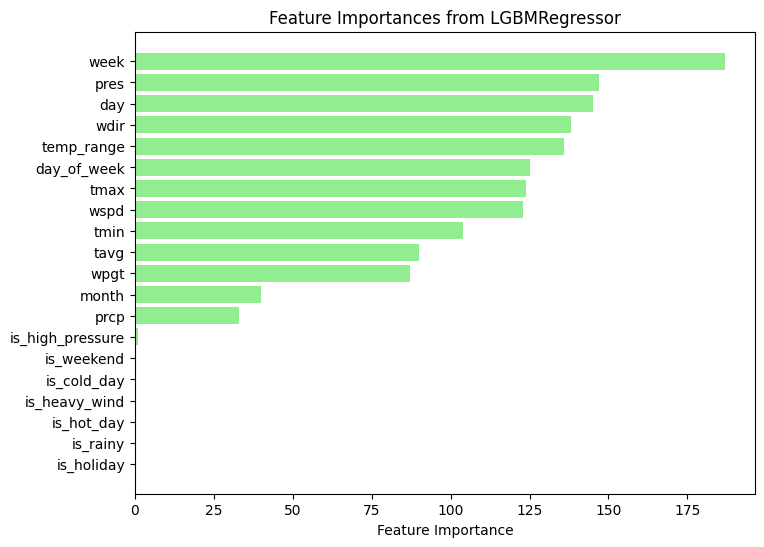

In [34]:
features = X_train.columns
importances = pd.DataFrame({
    'Feature': features,
    'Importance_ETR': feature_importances_etr,
    'Importance_LGBM': feature_importances_lgbm
})

importances_etr = importances.sort_values(by='Importance_ETR', ascending=False)
plt.figure(figsize=(8, 6))
plt.barh(importances_etr['Feature'], importances_etr['Importance_ETR'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from ExtraTreesRegressor')
plt.gca().invert_yaxis()
plt.show()

# importances = importances.sort_values(by='Importance_LGBM', ascending=False)
top_features_etr = importances_etr[:10]['Feature'].values
print(f'\nTop features from ExtraTreesRegressor: {top_features_etr}\n')

importances_lgbm = importances.sort_values(by='Importance_LGBM', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importances_lgbm['Feature'], importances_lgbm['Importance_LGBM'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from LGBMRegressor')
plt.gca().invert_yaxis()


top_features_lgbm = importances_lgbm[:10]['Feature'].values
print(f'\ntop features from LGBMRegressor:{top_features_lgbm}\n')
plt.show()


In [55]:

selection_list_features=set(correl_list).union(set(top_features_lgbm)).union(set(top_features_etr))
print(selection_list_features)

{'prcp', 'is_high_pressure', 'tmin', 'pres', 'wpgt', 'day', 'tmax', 'tavg', 'day_of_week', 'is_holiday', 'is_weekend', 'is_rainy', 'wdir', 'week', 'is_cold_day', 'is_hot_day', 'wspd', 'temp_range', 'is_heavy_wind', 'month'}


## Modeling

In [56]:
selection_list_features = [feature for feature in selection_list_features if (feature not in ['Article_Label','total_sale_item'])]

df_train=merged_data_no_oulier[selection_list_features]

X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size=0.3, random_state=42)


### CrossValidation on randomforestregressor

In [37]:


param_grid_rf = {'randomforestregressor__n_estimators': [100, 200,300],'randomforestregressor__max_depth': [10, 20]}

pipe_rf = make_pipeline( RandomForestRegressor())
grid_search_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error',  n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters found for RandomForestRegressor: ", best_params_rf)



Best parameters found for RandomForestRegressor:  {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 100}


#### RandomForestRegressor

In [57]:
rf_model = RandomForestRegressor(n_estimators=100,max_depth= 10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

final_y_pred_rf=np.round(y_pred).astype(int)
print(f'Final Mean Absolute Error Final Prediction: {mean_absolute_error(y_test, final_y_pred_rf)}')

Mean Absolute Error: 96.45255391098391
Final Mean Absolute Error Final Prediction: 96.45762711864407


,true,prediction,Final prediction
0,1269.0,1118.993139,1119
1,541.0,375.431329,375
2,584.0,608.742000,609
3,734.0,646.307833,646
4,886.0,945.358670,945
...,...,...,...
172,492.0,462.033898,462
173,503.0,376.857458,377
174,363.0,401.695773,402
175,337.0,421.075301,421


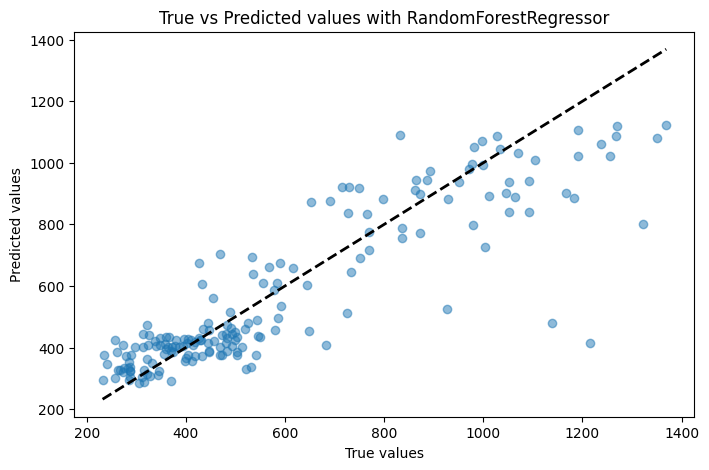

In [58]:
result_predict=zip(y_test,y_pred,final_y_pred_rf)
df_result_rf=pd.DataFrame(result_predict, columns=['true','prediction','Final prediction'])
display(df_result_rf)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted values with RandomForestRegressor')
plt.show()

### Test data Forcasting

In [44]:
X_test_=df_weather[df_weather['date']>='2022-09-30'][selection_list_features]


In [48]:
y_pred_ = rf_model.predict(X_test_)

final_y_pred_=np.round(y_pred_).astype(int)
df_result=pd.DataFrame(final_y_pred_,columns=['Prediction'])
df_result.reset_index(drop=True, inplace=True)
df_result.to_csv('prediction-result.csv', index=False)
df_result

,Prediction
0,377
1,598
2,906
3,401
4,407
5,403
6,407
7,428
8,696
9,857


## EDA

### Best Sellers

Top Selling Items:
                  Article        index  ticket_number  Quantity  \
138  TRADITIONAL BAGUETTE  17484243637   1.484361e+10  118093.0   
30              CROISSANT   2989010778   2.527759e+09   29822.0   
83       PAIN AU CHOCOLAT   2746027770   2.323578e+09   25367.0   
29                  COUPE   5132096047   4.449497e+09   23601.0   
5                 BANETTE   3810010248   3.286079e+09   22870.0   
2                BAGUETTE   3823527983   3.320439e+09   22156.0   
23        CEREAL BAGUETTE   1170784478   1.057516e+09    7478.0   
124         SPECIAL BREAD   1294655065   1.125667e+09    5488.0   
55       FORMULE SANDWICH   1045896336   9.017509e+08    5285.0   
133            TARTELETTE    712834265   6.198813e+08    5051.0   

     Article_Label  unit_price_value  
138        9361511          82980.75  
30          354888          12962.45  
83          884184          12971.90  
29          611580           3057.90  
5            90120          16224.45  
2        

<ipython-input-69-68cb09379f95>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Article', data=top_sellers, palette='viridis')


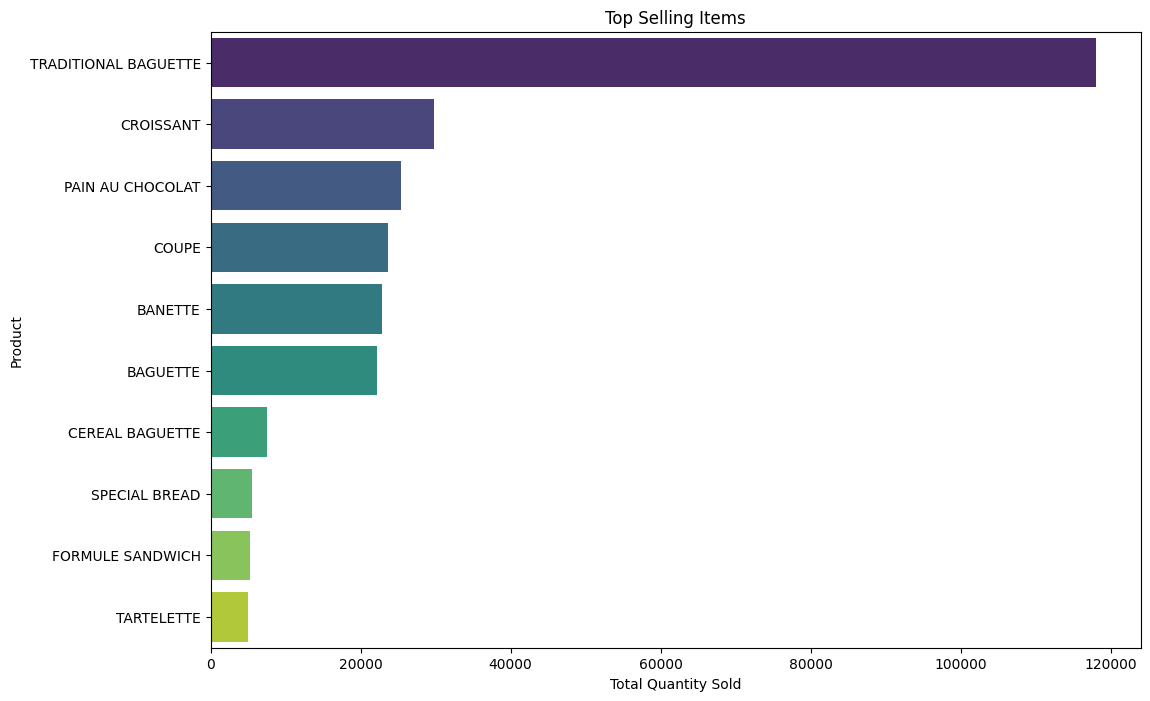

In [69]:


item_sales = df_bekery.groupby(['Article']).sum(['Quantity']).reset_index()

top_sellers = item_sales.sort_values(by='Quantity', ascending=False).head(10)

print("Top Selling Items:")
print(top_sellers)

plt.figure(figsize=(12, 8))
sns.barplot(x='Quantity', y='Article', data=top_sellers, palette='viridis')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.title('Top Selling Items')
plt.show()

### Daily Sale vs Weekend, Holidays, Rainy day

<ipython-input-116-379b2cf051a6>:45: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



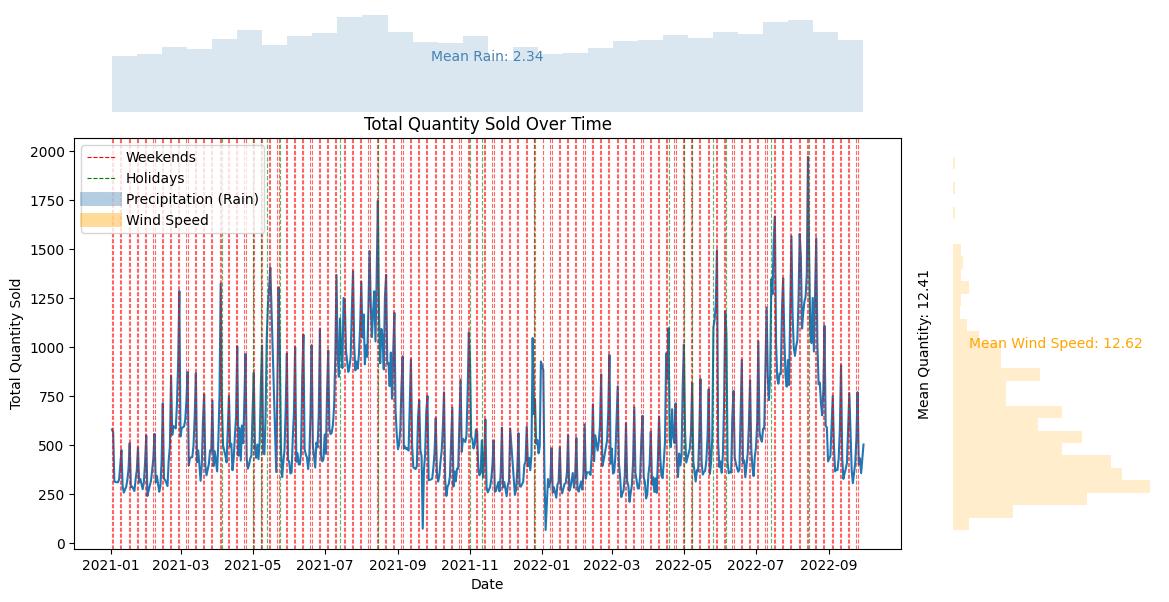

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

fig, ax = plt.subplots(2, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4], 'hspace': 0.1, 'wspace': 0.1})


ax[1, 0].plot(merged_data.groupby('date')['Quantity'].sum(), label='Total Quantity Sold')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Total Quantity Sold')
ax[1, 0].set_title('Total Quantity Sold Over Time')
weekends = merged_data[merged_data['is_weekend'] == 1]['date'].unique()
for weekend in weekends:
    ax[1, 0].axvline(x=weekend, color='red', linestyle='--', alpha=0.6, linewidth=0.8)

holidays = merged_data[merged_data['is_holiday'] == 1]['date'].unique()
for holiday in holidays:
    ax[1, 0].axvline(x=holiday, color='green', linestyle='--', alpha=0.6, linewidth=0.85)

ax[0, 0].hist(merged_data['date'][merged_data['prcp'].notnull()], bins=30, alpha=0.2, color='steelblue')
ax[0, 0].axis('off')

ax[1, 1].hist(merged_data['wspd'][merged_data['wspd'].notnull()], bins=30, orientation='horizontal', alpha=0.2, color='orange')
ax[1, 1].axis('off')

ax[0, 1].axis('off')

legend = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=0.8, label='Weekends'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=0.8, label='Holidays'),
    Line2D([0], [0], color='steelblue', alpha=0.4, linewidth=10, label='Precipitation (Rain)'),
    Line2D([0], [0], color='orange', alpha=0.4, linewidth=10, label='Wind Speed')
]
ax[1, 0].legend(handles=legend)

mean_rain = merged_data['prcp'].mean()
mean_wind_speed = merged_data['wspd'].mean()
mean_quantity = merged_data['Quantity'].mean()
ax[0, 0].annotate(f'Mean Rain: {mean_rain:.2f}', xy=(0.5, 0.5), xycoords='axes fraction', ha='center', fontsize=10, color='steelblue')
ax[1, 1].annotate(f'Mean Wind Speed: {mean_wind_speed:.2f}', xy=(0.5, 0.5), xycoords='axes fraction', va='center', ha='center', fontsize=10, color='orange')
ax[1, 0].annotate(f'Mean Quantity: {mean_quantity:.2f}', xy=(1.02, 0.5), xycoords='axes fraction', va='center', fontsize=10, color='black', rotation=90)


plt.tight_layout()
plt.show()


####High Sale days

In [117]:
peak_sale_date_list=merged_data.groupby('date')['Quantity'].sum().sort_values(ascending=False)[0:10]

for c,i in enumerate(peak_sale_date_list.index):
  print(f"{c+1} Highest Sales Day: {i.strftime('%Y-%m-%d')}, Quantity Sold:{peak_sale_date_list[i]}")
  is_holiday=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_holiday'].values[0]
  is_weekend=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_weekend'].values[0]
  day_name=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['day_name'].values[0]

  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_max_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmax'].values[0]
  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmin'].values[0]

  high_sale_rain_amount=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_wind_speed=weather[weather['date']==i.strftime('%Y-%m-%d')]['wspd'].values[0]
  print(f'Highest Sales Day Rain amount: {high_sale_rain_amount}, wind speed:{high_sale_wind_speed}')
  print(f'Highest Temperature:{high_sale_max_temprature}, minimum temperature{high_sale_min_temprature}')
  print(f'Holiday: {is_holiday}, day name:{day_name}\n')

1 Highest Sales Day: 2022-08-14, Quantity Sold:1970.0
Highest Sales Day Rain amount: 7.6, wind speed:12.4
Highest Temperature:31.6, minimum temperature18.2
Holiday: False, day name:Sunday

2 Highest Sales Day: 2021-08-15, Quantity Sold:1745.0
Highest Sales Day Rain amount: 0.0, wind speed:9.5
Highest Temperature:34.1, minimum temperature21.8
Holiday: True, day name:Sunday

3 Highest Sales Day: 2022-07-17, Quantity Sold:1664.0
Highest Sales Day Rain amount: 0.0, wind speed:10.3
Highest Temperature:31.5, minimum temperature16.7
Holiday: False, day name:Sunday

4 Highest Sales Day: 2022-08-07, Quantity Sold:1576.0
Highest Sales Day Rain amount: 0.0, wind speed:13.5
Highest Temperature:30.1, minimum temperature17.2
Holiday: False, day name:Sunday

5 Highest Sales Day: 2022-07-31, Quantity Sold:1565.0
Highest Sales Day Rain amount: 0.0, wind speed:11.0
Highest Temperature:32.6, minimum temperature18.0
Holiday: False, day name:Sunday

6 Highest Sales Day: 2022-08-21, Quantity Sold:1554.0
Hig

#### Least sale days

In [118]:
peak_sale_date_list=merged_data.groupby('date')['Quantity'].sum().sort_values(ascending=True)[0:10]

for c,i in enumerate(peak_sale_date_list.index):
  print(f"{c+1} Lowest Sales Day: {i.strftime('%Y-%m-%d')}, Quantity Sold:{peak_sale_date_list[i]}")
  is_holiday=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_holiday'].values[0]
  is_weekend=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_weekend'].values[0]
  day_name=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['day_name'].values[0]

  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_max_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmax'].values[0]
  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmin'].values[0]

  high_sale_rain_amount=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_wind_speed=weather[weather['date']==i.strftime('%Y-%m-%d')]['wspd'].values[0]
  print(f'Lowest Sales Day Rain amount: {high_sale_rain_amount}, wind speed:{high_sale_wind_speed}')
  print(f'Highest Temperature:{high_sale_max_temprature}, minimum temperature{high_sale_min_temprature}')
  print(f'Holiday: {is_holiday}, day name:{day_name}\n')

1 Lowest Sales Day: 2022-01-04, Quantity Sold:67.0
Lowest Sales Day Rain amount: 0.3, wind speed:31.3
Highest Temperature:13.3, minimum temperature7.8
Holiday: False, day name:Tuesday

2 Lowest Sales Day: 2021-09-22, Quantity Sold:74.0
Lowest Sales Day Rain amount: 0.0, wind speed:7.8
Highest Temperature:19.0, minimum temperature11.0
Holiday: False, day name:Wednesday

3 Lowest Sales Day: 2022-03-16, Quantity Sold:211.0
Lowest Sales Day Rain amount: 0.0, wind speed:17.5
Highest Temperature:17.8, minimum temperature9.2
Holiday: False, day name:Wednesday

4 Lowest Sales Day: 2022-03-30, Quantity Sold:228.0
Lowest Sales Day Rain amount: 0.3, wind speed:12.1
Highest Temperature:17.0, minimum temperature9.4
Holiday: False, day name:Wednesday

5 Lowest Sales Day: 2022-01-13, Quantity Sold:232.0
Lowest Sales Day Rain amount: 0.0, wind speed:5.0
Highest Temperature:1.5, minimum temperature-2.6
Holiday: False, day name:Thursday

6 Lowest Sales Day: 2022-03-09, Quantity Sold:235.0
Lowest Sales D

### Quantity sold vs day of the week


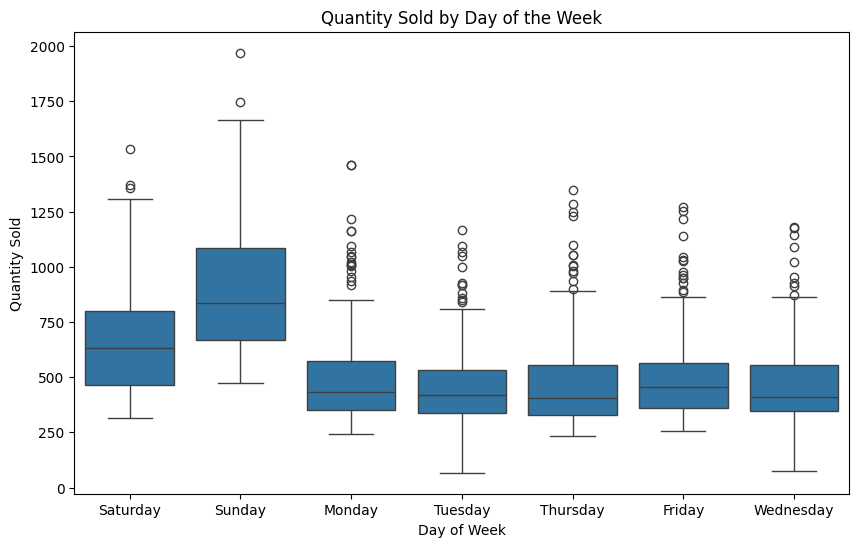

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
Friday,91.0,532.241758,251.116146,257.0,361.5,455.0,564.50,1269.0
Monday,88.0,545.545455,295.663637,241.0,349.0,432.5,574.25,1463.0
Saturday,90.0,691.555556,293.654582,313.0,464.5,632.0,801.00,1535.0
Sunday,91.0,919.714286,333.135417,475.0,670.5,837.0,1083.00,1970.0
Thursday,89.0,507.943820,274.225536,232.0,329.0,404.0,554.00,1346.0
Tuesday,89.0,480.887640,224.200876,67.0,337.0,417.0,533.00,1166.0
Wednesday,62.0,512.483871,265.371051,74.0,346.0,409.5,556.25,1181.0


In [46]:
total_sale_all_items=merged_data.groupby(['date'], as_index=False).sum()[['date','Quantity']]

total_sale_all_items['day_of_week'] = total_sale_all_items['date'].dt.dayofweek
total_sale_all_items['day_name']=total_sale_all_items['date'].dt.day_name()
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_name', y='Quantity', data=total_sale_all_items)
plt.xlabel('Day of Week')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold by Day of the Week')
plt.show()
stats_by_day = merged_data.groupby('day_name')['Quantity'].describe()
display(stats_by_day)

## Limitation


1.   'tsun' has no data
2.   'snow' feature only has 15 rows of data
3.   'date' has gap in between



In [138]:
def find_missing_dates(df:pd.DataFrame)->pd.DataFrame:
  """
  Finds date gaps in the given DataFrame.

  Args:
    dataset of weather or bakery
  Returns:
    returns date gaps
  """
  min_date = merged_data['date'].min()
  max_date = merged_data['date'].max()
  date_range = pd.date_range(start=min_date, end=max_date, freq='D')

  missing_dates = date_range[~date_range.isin(merged_data['date'])]

  return missing_dates

missing_dates = find_missing_dates(backery)
heading='<h3> Limitation in data</h3>'
title='<h4>Following dates are missing in the bakery dataset </h4>'
display(HTML(heading))
display(HTML(title))
print(missing_dates)


DatetimeIndex(['2021-01-06', '2021-01-13', '2021-01-20', '2021-01-27',
               '2021-02-03', '2021-02-10', '2021-02-17', '2021-02-24',
               '2021-03-03', '2021-03-10', '2021-03-17', '2021-03-24',
               '2021-03-31', '2021-04-07', '2021-05-17', '2021-05-18',
               '2021-05-19', '2021-05-20', '2021-11-17', '2021-11-24',
               '2021-12-01', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-15', '2022-01-01', '2022-01-05', '2022-01-12',
               '2022-01-19', '2022-01-26', '2022-02-02', '2022-02-09',
               '2022-02-16', '2022-02-23', '2022-05-04', '2022-09-01',
               '2022-09-19'],
              dtype='datetime64[ns]', freq=None)


In [139]:
len(missing_dates)

37